# Insolation Forest

In [1]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

/home/jorge/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/jorge/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [4]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

#csv_file = 'data/01_bronze/2018.csv'
#df = pd.read_csv(csv_file, parse_dates=[0], index_col=0, date_parser=parser)

In [ ]:
csv_file = 'data/01_bronze/2018.csv'
df = pd.read_csv(csv_file, sep=',',index_col=0)
df.shape

In [5]:
df = df[df['DEP_DELAY'].notna()]
df.shape

(7096212, 27)

In [6]:
# Quitamos las rows sin valores registrados para DEP_DELAY
#df_dep_delay = df[df['DEP_DELAY']>0]
df_dep_delay = df[df['DEP_DELAY'].notna()]
df.shape

(7096212, 27)

In [6]:
#df_dep_delay.info()
df_dep_delay.head()

,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
FL_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,UA,2429,EWR,DEN,1517,1512.0,-5.0,15.0,1527.0,1712.0,10.0,1745,1722.0,-23.0,0.0,NaN,0.0,268.0,250.0,225.0,1605.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,UA,2427,LAS,SFO,1115,1107.0,-8.0,11.0,1118.0,1223.0,7.0,1254,1230.0,-24.0,0.0,NaN,0.0,99.0,83.0,65.0,414.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,UA,2426,SNA,DEN,1335,1330.0,-5.0,15.0,1345.0,1631.0,5.0,1649,1636.0,-13.0,0.0,NaN,0.0,134.0,126.0,106.0,846.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,UA,2425,RSW,ORD,1546,1552.0,6.0,19.0,1611.0,1748.0,6.0,1756,1754.0,-2.0,0.0,NaN,0.0,190.0,182.0,157.0,1120.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,UA,2424,ORD,ALB,630,650.0,20.0,13.0,703.0,926.0,10.0,922,936.0,14.0,0.0,NaN,0.0,112.0,106.0,83.0,723.0,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
# quitamos las rows sin valores registrados para DEP_DELAY
df_dep_delay = df_dep_delay[df_dep_delay['DEP_DELAY'].notna()]
df_dep_delay.shape

(7096212, 27)

In [108]:
# calculamos promedio de demora de partida por origen y dia
df_mean_dep_delay = df_dep_delay.groupby(["ORIGIN", "FL_DATE"])["DEP_DELAY"]\
    .mean()\
    .to_frame('MEAN_DEP_DELAY')\
#.set_index('FL_DATE')
#.reset_index()
df_mean_dep_delay

MEAN_DEP_DELAY
ORIGIN FL_DATE                   
ABE    2018-01-01        7.833333
       2018-01-02       77.375000
       2018-01-03       51.333333
       2018-01-04       30.125000
       2018-01-05       17.375000
...                           ...
YUM    2018-12-27        4.250000
       2018-12-28        2.250000
       2018-12-29        3.500000
       2018-12-30        3.750000
       2018-12-31       21.000000

[121465 rows x 1 columns]

In [109]:
data = df_mean_dep_delay.loc['JFK',:]
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 2018-01-01 to 2018-12-31
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MEAN_DEP_DELAY  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7+ KB
None


,MEAN_DEP_DELAY
FL_DATE,
2018-01-01,18.311475
2018-01-02,18.047478
2018-01-03,10.893548
2018-01-04,71.066667
2018-01-05,154.356164


In [110]:
data.index = pd.to_datetime(data.index)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-01-01 to 2018-12-31
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MEAN_DEP_DELAY  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [111]:
# infer the frequency of the data
pd.infer_freq(data.index)

'D'

In [112]:
data = data.asfreq(pd.infer_freq(data.index))
data

,MEAN_DEP_DELAY
FL_DATE,
2018-01-01,18.311475
2018-01-02,18.047478
2018-01-03,10.893548
2018-01-04,71.066667
2018-01-05,154.356164
...,...
2018-12-27,4.470430
2018-12-28,29.405914
2018-12-29,13.348571


In [17]:
data['MEAN_DEP_DELAY'].describe()

count    365.000000
mean      12.414956
std       18.998573
min       -3.707237
25%        2.174041
50%        5.899721
75%       13.795455
max      154.356164
Name: MEAN_DEP_DELAY, dtype: float64

In [114]:
# Veamos cuantos puntos hay cerca del máximo
data.loc[data['MEAN_DEP_DELAY'] > 154]

,MEAN_DEP_DELAY
FL_DATE,
2018-01-05,154.356164


In [115]:
# Nos sacamos de encima el outlier point
data = data.loc[data['MEAN_DEP_DELAY'] < 154]

In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 364 entries, 2018-01-01 to 2018-12-31
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MEAN_DEP_DELAY  364 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [117]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

<AxesSubplot:xlabel='FL_DATE'>

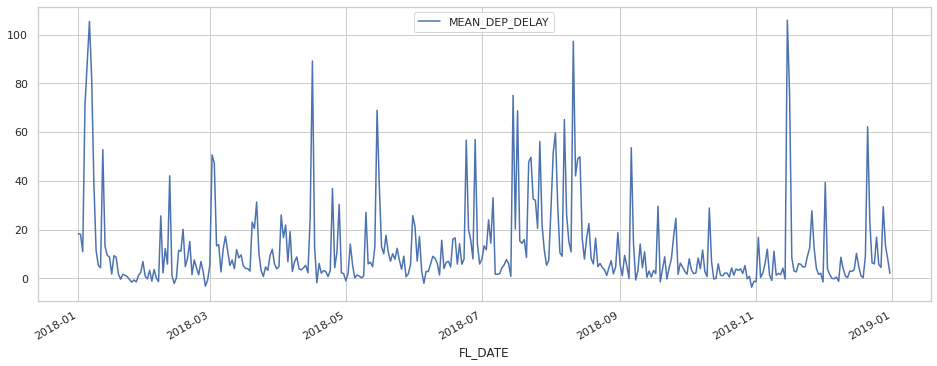

In [132]:
plt.rc('figure',figsize=(16,6))
plt.rc('font',size=15)
data.plot()

In [126]:
outliers_fraction = float(.01)

scaler = StandardScaler()
np_scaled = scaler.fit_transform(data.values.reshape(-1, 1))
data_scaled = pd.DataFrame(np_scaled, columns=['MEAN_DEP_DELAY'])

In [127]:
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data_scaled) 
IsolationForest(contamination=0.01)

IsolationForest(contamination=0.01)

In [128]:
data_scaled['anomaly'] = model.predict(data_scaled)

In [129]:
data_scaled['anomaly'].value_counts()

 1    360
-1      4
Name: anomaly, dtype: int64

In [130]:
data_scaled[data_scaled['anomaly']==-1]

,MEAN_DEP_DELAY,anomaly
4,5.342282,-1
104,4.416231,-1
221,4.879600,-1
317,5.373225,-1


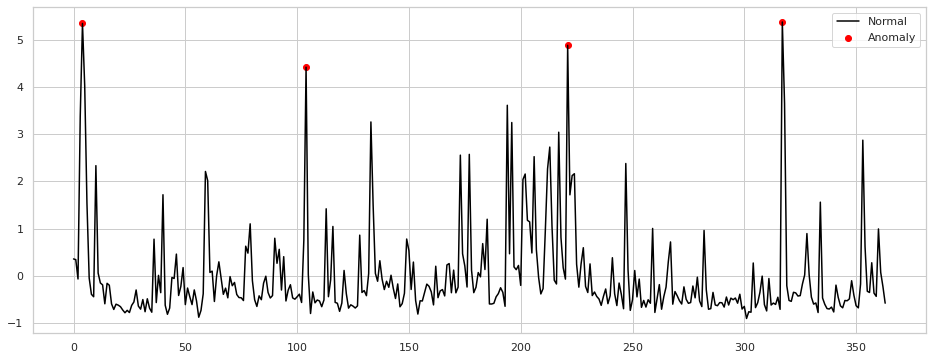

In [131]:
# visualization
fig, ax = plt.subplots(figsize=(16,6))

a = data_scaled.loc[data_scaled['anomaly'] == -1, ['MEAN_DEP_DELAY']] #anomaly

ax.plot(data_scaled.index, data_scaled['MEAN_DEP_DELAY'], color='black', label = 'Normal')
ax.scatter(a.index,a['MEAN_DEP_DELAY'], color='red', label = 'Anomaly')
plt.legend()
plt.show();